In [1]:
#def xop2_2d(g, f, a0, a):
from tqdm import tqdm
from tools.operators import xop_2d, yop_2d, Discrete1DGrid, RHSswe, RK3, initialize_vortex
from tools.plotting import VisualizeGrid, coLocateVelocity, StartPlot, UpdatePlot, StartPlotEnergy, UpdatePlotEnergy
from tools.tests import StabilityCheck, calc_diagnostics
import numpy as np
from matplotlib import pyplot as plt
import time

### Domain/setup
0 <= x <= 3600000, -1400000 <= y <= 1400000 <br>
Coriolis: f = f0 + By <br>
f0 = 9e-5
B=1.8e-11
depth: H = 1000 <br>
gravity: g = .081 <br>
tfinal: 160*24*2600

Stable timestep for coarsest resolution is dt = 0.02 (explain)

Use symmetry to update vorticity variables?

#### First Geometry - 80km resolution

In [2]:
#basin, resolution
xmin,xmax,N = 0, 3600000, 180
ymin,ymax,M = -1400000, 1400000, 140

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional
f0 = 9e-5
B = 1.8e-11
gravity = 0.081
depth = np.ones([M,N])*1000
coriolis = f0 + B*yz

In [3]:
%matplotlib

Using matplotlib backend: <object object at 0x0000022A5F029530>


In [4]:
plt.close('all')

### initial conditions


In [5]:
u,v,p = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0], dxs[1],
                         gravity, coriolis, a=39.5061,
                         L = 200000,
                         x_center = 900000, y_center = 0)

In [6]:
160*24*2600

9984000

In [7]:
periodic = False

alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = .001
# tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 160*24*4 #hourly = 169*24
isnap = 10       # frequency of visualization
finaltime = 160*24*2600
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

max. Courant number: 0.2925
Stable gravity wave time step:


In [8]:
#reset indices for diagnostic calculations depending on BCs
if periodic:
    ind1u,ind2u = 1,-1
    ind1v,ind2v = 1,-1
    ind1p,ind2p = 1,-1
    ind1z,ind2z = 1,-1
else:
    ind1u, ind2u = 0, len(u[0,])
    ind1v ,ind2v = 0, len(v[0,])
    ind1p ,ind2p = 0, len(p[0,])
    ind1z ,ind2z = 0, len(coriolis[0,])

In [9]:
initial_energy, initial_enstrophy, initial_mass = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

### ADJUST P LEVS FOR PRESSURE CONTOURS


In [10]:
#set pmin manually since it drops slightly from beginning
plevs=np.linspace(-10,40,40)
xas,yas=4,4

In [11]:
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='viridis')
plt.show()

In [12]:
total_system_energy = [initial_energy]
total_system_enstrophy = [initial_enstrophy]
total_system_mass = [initial_mass]
times = [0.0]


In [13]:
for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc,bdc=0,tau_x=0,tau_y=0, alin=1,periodic=periodic)
    if (it+1)%isnap==0:
        time.sleep(0.01)
        pcont = UpdatePlot(u,v,p,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='viridis') # update numerical plot

        times.append(timeCurrent)
        eg, es, ms = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy.append(eg)
        total_system_enstrophy.append(es)
        total_system_mass.append(ms)

  0%|          | 0/15360 [00:00<?, ?it/s]

 34%|███▍      | 5201/15360 [01:19<02:35, 65.26it/s]


KeyboardInterrupt: 

In [14]:
plt.close('all')

In [15]:
%matplotlib inline

In [16]:
mass_plot = np.array(total_system_mass)/initial_mass
energy_plot = np.array(total_system_energy)/initial_energy
enstrophy_plot = (np.array(total_system_enstrophy) + 1)/(initial_enstrophy+1)

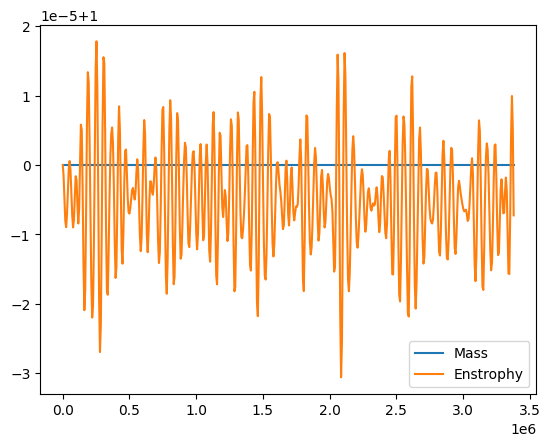

In [17]:
plt.plot(times,mass_plot, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
plt.plot(times,enstrophy_plot, label='Enstrophy')
plt.legend()
plt.show()